# Introducting to this notebook

In [ ]:
"""
What? Multithreading in XGBoost

The XGBoost library for gradient boosting uses is designed for efficient multi-core parallel processing. 
This allows it to efficiently use all of the CPU cores in your system when training.We will use the Otto 
Group Product Classification Challenge dataset. This dataset describes the 93 obfuscated details of more 
than 61,000 products grouped into 10 product categories (e.g. fashion, electronics, etc.). Input attributes
are counts of different events of some kind. The goal is to make predictions for new products as an array 
of probabilities for each of the 10 categories and models are evaluated using multiclass logarithmic loss
(also called cross entropy).

https://machinelearningmastery.com/best-tune-multithreading-support-xgboost-python/
"""

# Import python modules

In [1]:
import numpy
from time import time
import multiprocessing
from pylab import rcParams
from pandas import read_csv
from matplotlib import pyplot
from xgboost import XGBClassifier
from IPython.display import Markdown, display
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Loading dataset

In [5]:
# load data
data = read_csv('../DATASETS/train_Otto_classification.csv')
dataset = data.values
# split data into X and y
X = dataset[:,0:94]
y = dataset[:,94]

print("Input X shape: ", X.shape)
print("Label y shape: ", y.shape)

Input X shape:  (61878, 94)
Label y shape:  (61878,)


In [17]:
# Look at the first 5 lines of the .csv dataset
data.head(5)

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1


In [6]:
X[0]

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       1, 0, 4, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 5, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 11, 0, 1, 1, 0, 1,
       0, 7, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=object)

# Encoding

In [ ]:
"""
In this encoding technique, the categorical data is assigned a value from 1 to N (N is the number for different 
categories present in the data). This kind of an encoding technique is applied to the ordinal data. The assigning 
of the value from 1 to N happens either in an increasing or a decreasing order. This is ordering is a requirement.
"""

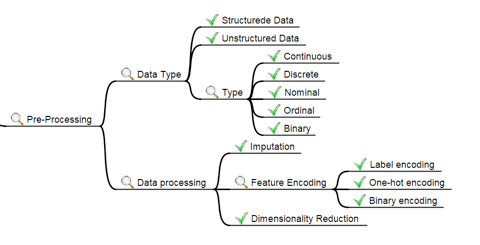

In [7]:
# Encode string class values as integers
print("BEFORE encoding: ", y[0])
label_encoded_y = LabelEncoder().fit_transform(y)
print("AFTER encoding: ", label_encoded_y[0])

BEFORE encoding:  Class_1
AFTER encoding:  0


# Evaluate the effect of the number of threads

In [8]:
print("This machine has: " + str(multiprocessing.cpu_count()) + " CPUs")

This machine has: 8 CPUs


In [9]:
results = []
num_threads = [1, 2, 3, 4, 5, 6, 7, 8]
for n in num_threads:
    print("Evaluation performance on " + str(n) + " CPUs")
    start = time()
    model = XGBClassifier(nthread=n)
    model.fit(X, label_encoded_y)
    elapsed = time() - start
    results.append(elapsed)

Evaluation performance on 1 CPUs
Evaluation performance on 2 CPUs
Evaluation performance on 3 CPUs
Evaluation performance on 4 CPUs
Evaluation performance on 5 CPUs
Evaluation performance on 6 CPUs
Evaluation performance on 7 CPUs
Evaluation performance on 8 CPUs


# Post-processing

In [10]:
print("Percentage improvement wrt serial [1 CPU]")
import numpy
for n in numpy.arange(8):
    print("|- CPUs No.: " + str(n+1) + ", improve rate: " + str( (results[n] - results[0]) / results[0] *100 ))

Percentage improvement wrt serial [1 CPU]
|- CPUs No.: 1, improve rate: 0.0
|- CPUs No.: 2, improve rate: -49.67491105186174
|- CPUs No.: 3, improve rate: -64.35701588438491
|- CPUs No.: 4, improve rate: -71.67283501022567
|- CPUs No.: 5, improve rate: -69.70657941989651
|- CPUs No.: 6, improve rate: -72.49571579032389
|- CPUs No.: 7, improve rate: -71.5941268444485
|- CPUs No.: 8, improve rate: -73.35029615414524


In [11]:
print("Percentage improvement wrt the previous one")
import numpy
for n in numpy.arange(0, 7):
    print("|- From: " + str(n+1) + " CPUs to " + str (n+2) + " CPUs, improve rate: " + str( (results[n+1] - results[n]) / results[n] *100 ))

Percentage improvement wrt the previous one
|- From: 1 CPUs to 2 CPUs, improve rate: -49.67491105186174
|- From: 2 CPUs to 3 CPUs, improve rate: -29.174523362797384
|- From: 3 CPUs to 4 CPUs, improve rate: -20.525271122391036
|- From: 4 CPUs to 5 CPUs, improve rate: 6.941236763505758
|- From: 5 CPUs to 6 CPUs, improve rate: -9.207069776264396
|- From: 6 CPUs to 7 CPUs, improve rate: 3.2779945807795343
|- From: 7 CPUs to 8 CPUs, improve rate: -6.18241622103956


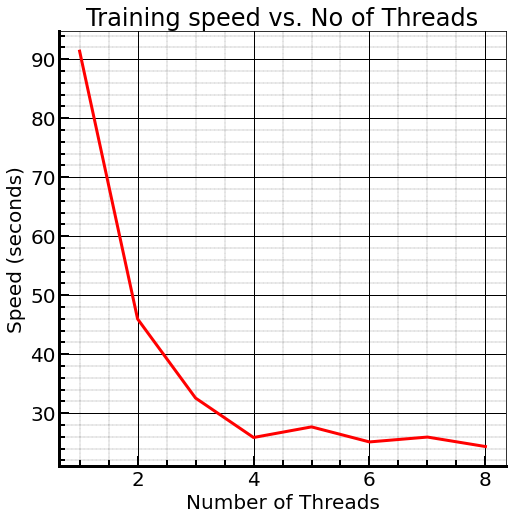

In [12]:
# Plot results
rcParams['figure.figsize'] = 8, 8
rcParams['font.size'] = 20

fig, ax = pyplot.subplots()
pyplot.title('Training speed vs. No of Threads') 

pyplot.plot(num_threads, results, "r-", lw = 3)
pyplot.ylabel('Speed (seconds)')
pyplot.xlabel('Number of Threads')

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.minorticks_on()

pyplot.show()

# Testing 3 different combinations

In [ ]:
"""
[1] Single thread trainig & parallel CV
[2] Parallel thread trainig & single thread CV
[3] Parallel thread trainig & parallel CV
"""

In [15]:
# prepare cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
# Single Thread XGBoost, Parallel Thread CV
start = time.time()
model = XGBClassifier(nthread=1)
results = cross_val_score(model, X, label_encoded_y, cv=kfold, scoring='neg_log_loss', n_jobs=-1)
elapsed = time.time() - start
print("Single Thread XGBoost, Parallel Thread CV: %f" % (elapsed))

Single Thread XGBoost, Parallel Thread CV: 270.145560


In [16]:
# Parallel Thread XGBoost, Single Thread CV
start = time.time()
model = XGBClassifier(nthread=-1)
results = cross_val_score(model, X, label_encoded_y, cv=kfold, scoring='neg_log_loss', n_jobs=1)
elapsed = time.time() - start
print("Parallel Thread XGBoost, Single Thread CV: %f" % (elapsed))

Parallel Thread XGBoost, Single Thread CV: 854.832747


In [17]:
# Parallel Thread XGBoost and CV
start = time.time()
model = XGBClassifier(nthread=-1)
results = cross_val_score(model, X, label_encoded_y, cv=kfold, scoring='neg_log_loss', n_jobs=-1)
elapsed = time.time() - start
print("Parallel Thread XGBoost and CV: %f" % (elapsed))

Parallel Thread XGBoost and CV: 263.126476


In [ ]:
"""
Excluding the obvious option of no parallelisation at all.

Best option    : paralleluse both model and CV
Worst option   : parallelise the model but not the CV
Lessons learnt : If you have to parallelise you are much better off parallelising the CV but than then model itself.
                 This makes sense as CV call the model in 10 different instances. Further running the classifier in 
                 parallel did not imporove the model much.
"""